In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import random_correlation
import matplotlib.pyplot as plt
from tqdm import tqdm

## Multidimensional Geometric Brownian Motion

In [2]:
T = 20 # time horizon
dt = 1/252 # discretisation
n = 10 # number of assets
N = 1000 # sample size on simplex

NT = int(T/dt) # time
grid = np.linspace(0,T,NT+1) # time grid

S0 = 100*np.ones(n) # initial prices
mu = 0.07*np.ones(n) # drifts
sigma = 0.25*np.ones(n) # volas

eig = np.random.uniform(0.1, 1, n) # 
eig = eig/np.sum(eig)*n # Sum of eigenvalues must equal dimensionality.
rho = random_correlation.rvs(eig) # 
Cov = np.tensordot(sigma, sigma, 0) * rho

In [3]:
def GBMsimulator(seed, n, S0, mu, sigma, Cov, T, NT):
    if seed:
        np.random.seed(seed) 
    A = np.linalg.cholesky(Cov)
    dW = np.random.normal(size = (n,NT)) * np.sqrt(dt)
    S = np.zeros([n, NT+1])
    S[:, 0] = S0
    for i in range(NT):    
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = np.matmul(A, dW[:,i])
        S[:, i+1] = S[:, i]*np.exp(drift + diffusion)
    return S.T

# S = GBMsimulator(None, n, S0, mu, sigma, Cov, T, NT)
# plt.plot(grid,S)
# plt.grid()

In [4]:
def OUsimulator(seed, n, S0, mean, theta, sigma, Cov, T, NT):
    if seed:
        np.random.seed(seed) 
    A = np.linalg.cholesky(Cov)
    dW = np.random.normal(size = (n,NT)) * np.sqrt(dt)
    S = np.zeros([n, NT+1])
    S[:, 0] = S0
    for i in range(NT):    
        drift = theta * (mean - S[:,i]) * dt
        diffusion = np.matmul(A, dW[:,i])*S[:,i]
        S[:, i+1] = S[:,i] + drift + diffusion
    return S.T

mean = 100*np.ones(n) # initial prices
theta = 0.07*np.ones(n) # mean reverting speed
sigma = 0.25*np.ones(n) # volas
# S = OUsimulator(None, n, S0, mean, theta, sigma, Cov, T, NT)
# plt.plot(grid,S)
# plt.grid()

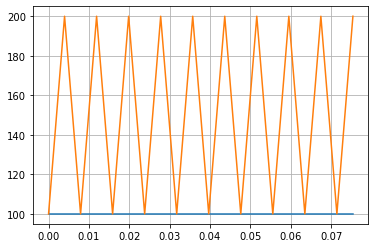

In [5]:
# Simple market 
n = 2
S_simple = np.ones([NT+1,2])
for i in range(NT+1):
    if i%2 == 0:
        S_simple[i] = np.array([100,100])
    else:
        S_simple[i] = np.array([100,200])
S_simple = np.array(S_simple)
plt.plot(grid[:20],S_simple[:20])
plt.grid()

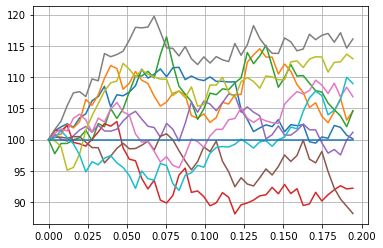

In [6]:
# BS model
def BSsimulator(seed, n, S0, mu, sigma, Cov, T, NT):
    S_bm = GBMsimulator(seed, n-1, S0, mu, sigma, Cov, T, NT)
    S_bond = np.ones([NT+1,1])*S0[0]
    S_BM = np.concatenate([S_bm,S_bond],axis = 1)
    return S_BM
S_BM = BSsimulator(None, 11, S0, mu, sigma, Cov, T, NT)
plt.plot(grid[:50],S_BM[:50])
plt.grid()

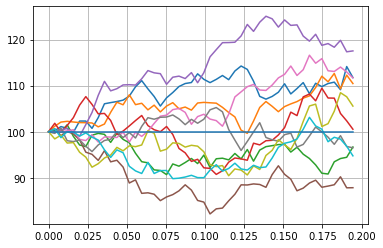

In [7]:
# mean-reverting model
def MVsimulator(seed, n, S0, mean, theta, sigma, Cov, T, NT):
    S_OU = OUsimulator(seed, n-1, S0, mean, theta, sigma, Cov, T, NT)
    S_bond = np.ones([NT+1,1])*S0[0]
    S_MV = np.concatenate([S_OU,S_bond],axis = 1)
    return S_MV
S_MV = MVsimulator(None, 11, S0, mean, theta, sigma, Cov, T, NT)
plt.plot(grid[:50],S_MV[:50])
plt.grid()

## Cover's Universal Portfolio 
is as good as the long run yield of the best retrospectively chosen constant rebalanced portfolio.

In [8]:
def wealth_update(weights,S):
    Vs = np.ones(NT+1)
    for i in range(NT):
        Rt = S[i+1]/S[i]
        Vs[i+1] = Vs[i] * (weights[i] * Rt).sum()
    return Vs

In [9]:
def compare_strategy(n,S,verbose = True):
    # best single
    Vsingle = np.max(S[-1]/S[0])
    
    # equal weight 
    # weight = np.zeros(n)
    # weight[2] = 1
    weight = np.ones(n)/n
    weights = np.tile(weight,[NT,1])
    V = wealth_update(weights,S)
    Vconstant = V[-1]
    
    # market 
    weights = np.ones([NT,n])/n
    for i in range(1,NT):
        weights[i] = S[i,:] / S[i,:].sum()
    V = wealth_update(weights,S)
    Vmarket = V[-1]
    
    # uniform strategies
    simplex_uniform = np.random.exponential(scale=1.0, size=[N,n])
    simplex_uniform = simplex_uniform / np.sum(simplex_uniform,axis=-1,keepdims = True)
    Vuniform = []
    for j,weight in enumerate(simplex_uniform):
        weights = np.tile(weight,[NT,1])
        V = wealth_update(weights,S)
        Vuniform.append(V)
    Vuniform = np.array(Vuniform)
    
    # best constant rebalanced portfolio strategy
    Vbest = np.max(Vuniform[:,-1])

    # adapted strategy 
    weights = np.ones([NT,n])/n
    for i in range(1,NT):
        weights[i] = np.mean(simplex_uniform*Vuniform[:,i,None],axis=0) / np.mean(Vuniform[:,i])
    V = wealth_update(weights,S)
    Vadapted = V[-1]
    
    if verbose:
        print('best single: ',Vsingle)
        print('adaptive rebalanced: ',Vadapted)
        print('best: ',Vbest)
        print('equally weighted: ',Vconstant)
        print('market portfolio: ',Vmarket)
    
    return Vsingle, Vconstant, Vbest, Vadapted, Vmarket

In [10]:
Vsingle, Vconstant, Vbest, Vadapted, Vmarket = compare_strategy(2,S_simple)

best single:  1.0
adaptive rebalanced:  4.024737484313968e+127
best:  8.021057447052048e+128
equally weighted:  8.023365328216683e+128
market portfolio:  1.0


In [11]:
Vsingle, Vconstant, Vbest, Vadapted, Vmarket = compare_strategy(11,S_BM)

best single:  18.69172414771707
adaptive rebalanced:  4.370182507854504
best:  10.338772873724148
equally weighted:  4.200678116775348
market portfolio:  5.1914014929187475


In [12]:
Vsingle, Vconstant, Vbest, Vadapted, Vmarket = compare_strategy(11,S_MV)

best single:  1.4740997804115212
adaptive rebalanced:  1.3993404761161645
best:  1.9369431894361904
equally weighted:  1.4484318641075145
market portfolio:  0.9246649956092868


In [13]:
trials = 10
def test(trials):
    Vsingle_list = np.zeros(trials)
    Vconstant_list = np.zeros(trials)
    Vbest_list = np.zeros(trials)
    Vadapted_list = np.zeros(trials)
    Vmarket_list = np.zeros(trials)
    for trial in tqdm(range(trials)):
        S = MVsimulator(None, 11, S0, mean, theta, sigma, Cov, T, NT)
        Vsingle, Vconstant, Vbest, Vadapted, Vmarket = compare_strategy(11,S, False)
        Vsingle_list[trial] = Vsingle
        Vconstant_list[trial] = Vconstant
        Vbest_list[trial] = Vbest
        Vadapted_list[trial] = Vadapted
        Vmarket_list[trial] = Vmarket
    return Vsingle_list, Vconstant_list, Vbest_list, Vadapted_list, Vmarket_list
Vsingle_list, Vconstant_list, Vbest_list, Vadapted_list, Vmarket_list = test(10)

100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]


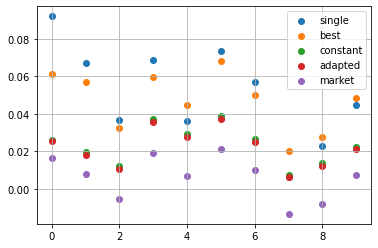

In [14]:
plt.scatter(np.arange(trials),np.log(Vsingle_list)/T,label = 'single')
plt.scatter(np.arange(trials),np.log(Vbest_list)/T,label = 'best')
plt.scatter(np.arange(trials),np.log(Vconstant_list)/T,label = 'constant')
plt.scatter(np.arange(trials),np.log(Vadapted_list)/T,label = 'adapted')
plt.scatter(np.arange(trials),np.log(Vmarket_list)/T,label = 'market')
plt.legend()
plt.grid()

## The Market Portfolio 
from Fernholz Stochastic Portfolio Theory, where rebalancing rule need not to be constant anymore but may depend on the present state of
the stock market

## Log-optimal Numeraire Portfolio
not model-free but for comparision
